# CNN-CAtt-ConvLSTM

In [ ]:
import pandas as pd
import numpy as np
import glob
import cv2
import os
import scipy.io
import tensorflow as tf

the model is composed of a CNN for attribute feature extraction, a CAtt mechanism for re-adjusting the correlated feature responses of pedestrian attributes, and ConvLSTM for mining correlation and spatial information between different attributes. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#!unzip -P "casia_cripac_isee_5610" "/gdrive/My Drive/RAP_dataset.zip" -d "/gdrive/My Drive/RAP_dataset"
#!unzip -P "casia_cripac_isee_5610" "/gdrive/My Drive/RAP_annotation.zip" -d "/gdrive/My Drive"

In [ ]:
# !ls "/gdrive/My Drive/RAP_dataset"

# mat tp csv

In [ ]:
#!ls "/gdrive/My Drive/RAP_annotation"

In [ ]:
mat = scipy.io.loadmat('/gdrive/MyDrive/RAP_annotation/RAP_annotation.mat')

In [ ]:
# mat['RAP_annotation']

In [ ]:
mat['__globals__']

[]

In [ ]:
mat['__header__']

b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue May 22 23:42:10 2018'

In [ ]:
mat['__version__']

'1.0'

In [ ]:
x = mat['RAP_annotation'].ravel()

In [ ]:
x = pd.DataFrame(x)

In [ ]:
x

,partion,label,attribute_chinese,attribute_eng,position,imagesname,attribute_exp
0,"[[[[(array([[ 5211, 17913, 25729, ..., 1982, ...","[[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,...","[[[性别]], [[年龄16]], [[年龄30]], [[年龄45]], [[体型微胖]...","[[[Female]], [[AgeLess16]], [[Age17-30]], [[Ag...","[[693, 16, 124, 254, 731, 21, 54, 49, 708, 56,...",[[[CAM31_2014-03-18_20140318125002-20140318125...,"[[[Female]], [[AgeLess16]], [[Age17-30]], [[Ag..."


RAP_annotation.partion is the 5 random partion for training and test, which is the same as the setting in our paper.

In [ ]:
x.columns

Index(['partion', 'label', 'attribute_chinese', 'attribute_eng', 'position',
       'imagesname', 'attribute_exp'],
      dtype='object')

In [ ]:
# x['partion'][0][0][0][0][0][0]

In [ ]:
len(x['label'][0])

41585

In [ ]:
len(x['attribute_chinese'][0][0])

1

In [ ]:
len(x['imagesname'][0])

41585

In [ ]:
for i in x:
  print(x[i],'\n')

0    [[[[(array([[ 5211, 17913, 25729, ...,  1982, ...
Name: partion, dtype: object 

0    [[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,...
Name: label, dtype: object 

0    [[[性别]], [[年龄16]], [[年龄30]], [[年龄45]], [[体型微胖]...
Name: attribute_chinese, dtype: object 

0    [[[Female]], [[AgeLess16]], [[Age17-30]], [[Ag...
Name: attribute_eng, dtype: object 

0    [[693, 16, 124, 254, 731, 21, 54, 49, 708, 56,...
Name: position, dtype: object 

0    [[[CAM31_2014-03-18_20140318125002-20140318125...
Name: imagesname, dtype: object 

0    [[[Female]], [[AgeLess16]], [[Age17-30]], [[Ag...
Name: attribute_exp, dtype: object 



In [ ]:
label = x['label'][0]
attribute_eng = x['attribute_eng'][0]
imagesname = x['imagesname'][0]
position = x['position'][0]

In [ ]:
len(label)

41585

In [ ]:
len(attribute_eng)

92

In [ ]:
attribute_eng[0][0][0]

'Female'

In [ ]:
attributes = []
for i in attribute_eng:
   attributes.append(i[0][0])

In [ ]:
len(imagesname)

41585

In [ ]:
imagesname = imagesname.flatten()

In [ ]:
len(imagesname)

41585

In [ ]:
imagesname[0]
names = []
for i in imagesname:
  names.append(i[0])

In [ ]:
len(names)

41585

In [ ]:
type(imagesname)

numpy.ndarray

In [ ]:
label

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int32)

In [ ]:
label.shape

(41585, 92)

In [ ]:
len(position)

41585

In [ ]:
df = pd.DataFrame(label, columns = attributes)
print(df)

       Female  AgeLess16  Age17-30  ...  shoes-Yellow  shoes-Brown  shoes-Mixture
0           1          0         0  ...             0            0              0
1           0          0         0  ...             0            0              0
2           1          0         0  ...             0            0              0
3           0          0         1  ...             0            0              0
4           0          0         0  ...             0            0              0
...       ...        ...       ...  ...           ...          ...            ...
41580       0          0         1  ...             0            0              0
41581       1          1         0  ...             1            0              0
41582       1          0         1  ...             0            0              0
41583       0          1         0  ...             0            0              0
41584       0          1         0  ...             0            0              0

[41585 rows x 9

In [ ]:
df.insert(0,"ImageName",names)

In [ ]:
df.head()

,ImageName,Female,AgeLess16,Age17-30,Age31-45,BodyFat,BodyNormal,BodyThin,Customer,Clerk,hs-BaldHead,hs-LongHair,hs-BlackHair,hs-Hat,hs-Glasses,hs-Muffler,ub-Shirt,ub-Sweater,ub-Vest,ub-TShirt,ub-Cotton,ub-Jacket,ub-SuitUp,ub-Tight,ub-ShortSleeve,lb-LongTrousers,lb-Skirt,lb-ShortSkirt,lb-Dress,lb-Jeans,lb-TightTrousers,shoes-Leather,shoes-Sport,shoes-Boots,shoes-Cloth,shoes-Casual,attach-Backpack,attach-SingleShoulderBag,attach-HandBag,attach-Box,...,faceBack,faceLeft,faceRight,occlusionLeft,occlusionRight,occlusionUp,occlusionDown,occlusion-Environment,occlusion-Attachment,occlusion-Person,occlusion-Other,up-Black,up-White,up-Gray,up-Red,up-Green,up-Blue,up-Yellow,up-Brown,up-Purple,up-Pink,up-Orange,up-Mixture,low-Black,low-White,low-Gray,low-Red,low-Green,low-Blue,low-Yellow,low-Mixture,shoes-Black,shoes-White,shoes-Gray,shoes-Red,shoes-Green,shoes-Blue,shoes-Yellow,shoes-Brown,shoes-Mixture
0,CAM31_2014-03-18_20140318125002-20140318125546...,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,CAM31_2014-03-18_20140318125002-20140318125546...,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CAM31_2014-03-18_20140318125002-20140318125546...,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,CAM31_2014-03-18_20140318125002-20140318125546...,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0
4,CAM31_2014-03-18_20140318125002-20140318125546...,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.columns

Index(['ImageName', 'Female', 'AgeLess16', 'Age17-30', 'Age31-45', 'BodyFat',
       'BodyNormal', 'BodyThin', 'Customer', 'Clerk', 'hs-BaldHead',
       'hs-LongHair', 'hs-BlackHair', 'hs-Hat', 'hs-Glasses', 'hs-Muffler',
       'ub-Shirt', 'ub-Sweater', 'ub-Vest', 'ub-TShirt', 'ub-Cotton',
       'ub-Jacket', 'ub-SuitUp', 'ub-Tight', 'ub-ShortSleeve',
       'lb-LongTrousers', 'lb-Skirt', 'lb-ShortSkirt', 'lb-Dress', 'lb-Jeans',
       'lb-TightTrousers', 'shoes-Leather', 'shoes-Sport', 'shoes-Boots',
       'shoes-Cloth', 'shoes-Casual', 'attach-Backpack',
       'attach-SingleShoulderBag', 'attach-HandBag', 'attach-Box',
       'attach-PlasticBag', 'attach-PaperBag', 'attach-HandTrunk',
       'attach-Other', 'action-Calling', 'action-Talking', 'action-Gathering',
       'action-Holding', 'action-Pusing', 'action-Pulling',
       'action-CarrybyArm', 'action-CarrybyHand', 'faceFront', 'faceBack',
       'faceLeft', 'faceRight', 'occlusionLeft', 'occlusionRight',
       'occlusionUp

In [ ]:
position = position/position.max()

In [ ]:
len(position)

41585

In [ ]:
[position[1]]

[array([0.45905512, 0.00393701, 0.09133858, 0.22677165, 0.46456693,
        0.00472441, 0.07637795, 0.05590551, 0.45984252, 0.04015748,
        0.08976378, 0.10866142, 0.47559055, 0.10787402, 0.07244094,
        0.11968504])]

In [ ]:
df['position'] = [[i] for i in position]

In [ ]:
df.head(3)

,ImageName,Female,AgeLess16,Age17-30,Age31-45,BodyFat,BodyNormal,BodyThin,Customer,Clerk,hs-BaldHead,hs-LongHair,hs-BlackHair,hs-Hat,hs-Glasses,hs-Muffler,ub-Shirt,ub-Sweater,ub-Vest,ub-TShirt,ub-Cotton,ub-Jacket,ub-SuitUp,ub-Tight,ub-ShortSleeve,lb-LongTrousers,lb-Skirt,lb-ShortSkirt,lb-Dress,lb-Jeans,lb-TightTrousers,shoes-Leather,shoes-Sport,shoes-Boots,shoes-Cloth,shoes-Casual,attach-Backpack,attach-SingleShoulderBag,attach-HandBag,attach-Box,...,faceLeft,faceRight,occlusionLeft,occlusionRight,occlusionUp,occlusionDown,occlusion-Environment,occlusion-Attachment,occlusion-Person,occlusion-Other,up-Black,up-White,up-Gray,up-Red,up-Green,up-Blue,up-Yellow,up-Brown,up-Purple,up-Pink,up-Orange,up-Mixture,low-Black,low-White,low-Gray,low-Red,low-Green,low-Blue,low-Yellow,low-Mixture,shoes-Black,shoes-White,shoes-Gray,shoes-Red,shoes-Green,shoes-Blue,shoes-Yellow,shoes-Brown,shoes-Mixture,position
0,CAM31_2014-03-18_20140318125002-20140318125546...,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,"[[0.5456692913385827, 0.012598425196850394, 0...."
1,CAM31_2014-03-18_20140318125002-20140318125546...,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[[0.4590551181102362, 0.003937007874015748, 0...."
2,CAM31_2014-03-18_20140318125002-20140318125546...,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,"[[0.5204724409448819, 0.013385826771653543, 0...."


In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, Concatenate , Dense, Dropout, Flatten
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

We only choose the first 3000 rows off the dataset in other to time saviing.

In [ ]:
images_directory = '/gdrive/My Drive/RAP_dataset/RAP_dataset/'

In [ ]:
SAMPLE_SIZE = 3000

In [ ]:
df1 = df.iloc[:SAMPLE_SIZE]

In [ ]:
SIZE = 100

In [ ]:
X_dataset = []
for i in tqdm(range(df1.shape[0])):
  img = image.load_img(images_directory+df1['ImageName'][i], target_size=(SIZE, SIZE, 3))
  img = image.img_to_array(img)
  img = img /255.
  X_dataset.append(img)

In [ ]:
X = np.array(X_dataset)

In [ ]:
X.shape

(3000, 100, 100, 3)

In [ ]:
y = np.array(df1.drop(['ImageName'], axis=1))

In [ ]:
X_train, X_test, y_tra, y_te = train_test_split(X, y, random_state=20, test_size=0.3)

In [ ]:
pos_train = tf.convert_to_tensor(np.array([y_tra[i][92] for i in range(len(y_tra))]).reshape(len(y_tra),16))
pos_test = tf.convert_to_tensor(np.array([y_te[i][92] for i in range(len(y_te))]).reshape(len(y_te),16))

y_train = tf.convert_to_tensor( [y_tra[i][:92] for i in range(len(y_tra))])
y_test = tf.convert_to_tensor( [y_te[i][:92] for i in range(len(y_te))])

In [ ]:
len(y_train[1])

92

In [ ]:
len(pos_train[1])

16

Model 1:

In [ ]:
model_cnn = Sequential()

model_cnn.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(SIZE,SIZE,3)))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.2))

model_cnn.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2))

model_cnn.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2))

model_cnn.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2))

model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(92, activation='sigmoid'))
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 22, 32)        1

In [ ]:
model_mlp = Sequential()

model_mlp.add(Dense(16 , input_dim = 16, activation = 'relu'))
model_mlp.add(Dense(8 , activation = 'relu'))
model_mlp.add(Dense(4, activation="relu"))
model_mlp.add(Dense(4, activation="linear"))

In [ ]:
model_concat = Concatenate(axis = 1)([model_mlp.output , model_cnn.output])

model_concat = Dense(32, activation="relu")(model_concat)
model_concat = Dropout(0.2)(model_concat)
model_concat = Dense(50, activation="relu")(model_concat)
model_concat = Dense(92, activation="relu")(model_concat)
model_concat = Dense(92, activation="sigmoid")(model_concat)

model_concat = Model(inputs=[model_mlp.input, model_cnn.input], outputs=model_concat)

In [ ]:
model_concat.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [ ]:
es1 = EarlyStopping(monitor='binary_accuracy', verbose=1,mode = 'max', patience=7)
es2 = EarlyStopping(monitor='val_loss', verbose=1, patience=7,mode = 'min' ) #when validation loss starts to increase means we start overfitting so it stops after 5 epochs
eses = [es1,es2]

history = model_concat.fit( x = [pos_train,X_train], y = y_train, epochs=100, validation_data=([pos_test,X_test], y_test), batch_size=64, callbacks= eses ,verbose = 1)

Epoch 1/100
33/33 [==============================] - 36s 1s/step - loss: 0.6001 - binary_accuracy: 0.6713 - val_loss: 0.3195 - val_binary_accuracy: 0.8745
Epoch 2/100
33/33 [==============================] - 34s 1s/step - loss: 0.3218 - binary_accuracy: 0.8721 - val_loss: 0.3049 - val_binary_accuracy: 0.8751
Epoch 3/100
33/33 [==============================] - 34s 1s/step - loss: 0.3078 - binary_accuracy: 0.8748 - val_loss: 0.3053 - val_binary_accuracy: 0.8732
Epoch 4/100
33/33 [==============================] - 34s 1s/step - loss: 0.3042 - binary_accuracy: 0.8774 - val_loss: 0.3179 - val_binary_accuracy: 0.8727
Epoch 5/100
33/33 [==============================] - 34s 1s/step - loss: 0.3002 - binary_accuracy: 0.8792 - val_loss: 0.3193 - val_binary_accuracy: 0.8684
Epoch 6/100
33/33 [==============================] - 34s 1s/step - loss: 0.2954 - binary_accuracy: 0.8795 - val_loss: 0.2984 - val_binary_accuracy: 0.8768
Epoch 7/100
33/33 [==============================] - 34s 1s/step - los

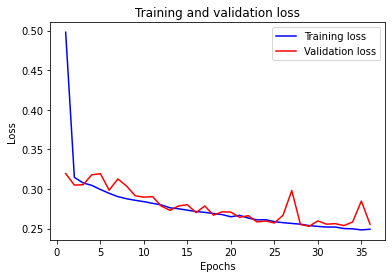

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

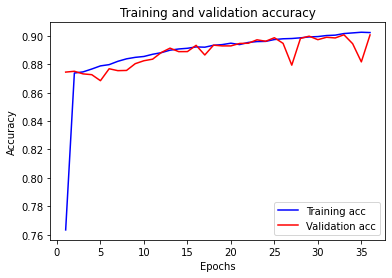

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

What if we set y_train to all zero?

Does our network really work or it's just about sparsity of the labels and being the most elements zero?

In [ ]:
y_train_zeros = tf.convert_to_tensor(np.float32(np.zeros(y_train.shape)))
y_train = tf.convert_to_tensor(np.float32(y_train))

accs = []
for i in range(200):
  m = tf.keras.metrics.BinaryAccuracy()
  m.update_state(y_train_zeros[i], y_train[i])
  accs.append(m.result().numpy())
  
np.mean(accs)

0.84684783

We did a little bit better :))

In [ ]:
import random
TEST_NO = random.randint(0,SAMPLE_SIZE)

In [ ]:
TEST_NO

2157

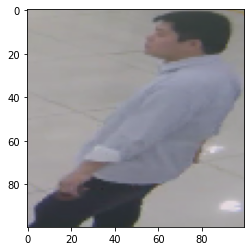

In [ ]:
img = image.load_img(images_directory+df['ImageName'][TEST_NO], target_size=(SIZE, SIZE, 3))
img = image.img_to_array(img)
img = img /255.
plt.imshow(img)

In [ ]:
img.shape

(100, 100, 3)

In [ ]:
img = np.expand_dims(img, axis=0)

In [ ]:
img.shape

(1, 100, 100, 3)

In [ ]:
classes = np.array(df.columns[2:])#get array of all classes
proba = model_concat.predict( [np.array(df['position'][TEST_NO]).reshape(1,16) , img] )#Get probabilities for each class
sorted_categories = np.argsort(proba[0])[:-11:-1]#Get class names for top 10 classes

In [ ]:
#print classes and corresponding probabilities
for i in range(10):
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))


occlusion-Environment (0.993)
Clerk (0.927)
hs-Hat (0.917)
BodyThin (0.759)
up-Black (0.725)
BodyFat (0.579)
lb-Skirt (0.454)
low-White (0.451)
AgeLess16 (0.434)
up-White (0.38)


In [ ]:
import joblib
joblib.dump(value=model_concat.weights, filename=f"weights_pr4-1.pkl")

['weights_pr4-1.pkl']